In [1]:
%matplotlib inline
import random
import pandas as pd
import numpy as np
import sklearn.preprocessing as preprocessing
import math
#import cvxpy as cp
import matplotlib.pyplot as plt


/Users/lixudong/miniforge3/envs/rl2021/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
def data_transform(df):
    """Normalize features."""
    binary_data = pd.get_dummies(df)
    feature_cols = binary_data[binary_data.columns[:-2]]
    scaler = preprocessing.StandardScaler()
    data = pd.DataFrame(scaler.fit_transform(feature_cols), columns=feature_cols.columns)
    return data

In [3]:
features = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"] 

In [4]:
train_url = 'adult/adult.data'
test_url = 'adult/adult.test'

original_train = pd.read_csv(train_url, names=features, sep=r'\s*,\s*', 
                             engine='python', na_values="?")
original_test = pd.read_csv(test_url, names=features, sep=r'\s*,\s*', 
                            engine='python', na_values="?", skiprows=1)

In [5]:
num_train = len(original_train)
original = pd.concat([original_train, original_test])
roc_original = original
labels = original['Target']
labels = labels.replace('<=50K', 0).replace('>50K', 1)
labels = labels.replace('<=50K.', 0).replace('>50K.', 1)
sensitive = original['Sex']
sensitive = sensitive.replace('Male', 0).replace('Female', 1)
# Redundant column
del original["Education"]
# Remove target variable
del original["Target"]
#del original["Sex"]


In [6]:
#binary_data = pd.get_dummies(original)
#data=pd.concat([binary_data, sensitive], axis=1)
data = data_transform(original)

train_data = data[:num_train].values
train_labels = labels[:num_train].values
test_data = data[num_train:].values
test_labels = labels[num_train:].values
dim = train_data.shape[1]

/Users/lixudong/miniforge3/envs/rl2021/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/lixudong/miniforge3/envs/rl2021/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


In [7]:
X_data = np.concatenate((train_data, test_data), axis=0)
Y_data = np.concatenate((train_labels, test_labels), axis=0)
num_total = np.size(Y_data)

Let $p = \text{Prob}(y=1)$, 
\begin{align}
F(\theta,a,b,\alpha; x,y ) & = (1- p)(\theta^\top x - a)^2 \mathbb{I}[y=1] + p(\theta^\top x - b)^2 \mathbb{I} [y=-1] 
\\
&\quad + 2(1+\alpha) \Big (p \theta^\top x \mathbb{I}[y = -1] - (1-p)\theta^\top x \mathbb{I}[y=1] \Big ) - p(1-p)\alpha^2
\end{align}
and 
\begin{align}
\nabla_\theta F(\theta,a,b,\alpha; x,y ) & = 2x (1- p)(\theta^\top x - a)\mathbb{I}[y=1] + 2x p(\theta^\top x - b) \mathbb{I} [y=-1] 
\\
&\quad + 2(1+\alpha) \Big (p  x \mathbb{I}[y = -1] - (1-p) x \mathbb{I}[y=1] \Big ) ,
\\
\nabla_a F(\theta,a,b,\alpha; x,y ) & = 2(1- p)( a - \theta^\top x ) \mathbb{I}[y=1],
\\
\nabla_b F(\theta,a,b,\alpha; x,y ) & =  2p(b - \theta^\top x ) \mathbb{I} [y=-1] 
\\
\nabla_\alpha F(\theta,a,b,\alpha; x,y ) & =  2\Big (p \theta^\top x \mathbb{I}[y = -1] - (1-p)\theta^\top x \mathbb{I}[y=1] \Big ) - 2p(1-p)\alpha
\end{align}

In [8]:
def loss(X,Y,theta):
    eta=np.dot(X,theta)
    return -(np.dot(Y,eta)-np.sum(np.log(1+np.exp(eta))))

def f_grad_x(x,y,theta,a,b,alpha,p,coef):
    
    res = np.zeros(dim)
    
    if y == 1:
        res = 2*x*(1-p)*(np.dot(x,theta) - a) + 2*(1+ alpha)*(p-1)* x
    else:
        res = 2*x* p*(np.dot(x,theta) - b) + 2*(1+alpha)*p*x
    return res + coef* x

def f_grad_a(x,y,theta,a,b,alpha,p):
    return 2*(1-p)*(a - np.dot(x,theta))

def f_grad_b(x,y,theta,a,b,alpha,p):
    return 2*p*(b - np.dot(x,theta))

def f_grad_alpha(x,y,theta,a,b,alpha,p):
    
    if y == 1:
        temp = -(1-p)*np.dot(theta,x) 
    else:
        temp = p*np.dot(theta,x) 
    
    return 2*temp - 2*p*(1-p)*alpha


def predict(theta,X):
    y =1/(1+np.exp(-np.dot(X,theta)))
    return np.array((y.T>0.5).reshape(-1)).astype(int)

def constraints(X,theta,z,c):
#     length=z.shape
    length = 1
    #print(length)
    return np.array([np.dot(z,np.dot(X,theta))/length-c,-np.dot(z,np.dot(X,theta))/length-c]).reshape(-1)

def g_grad(X,z):
    length= 1
    return np.array([np.dot(z,X)/length,-np.dot(z,X)/length])

In [10]:
theta_0=np.ones(dim)
Z=sensitive.values
Z_data=Z-Z.mean()
# Z_train=Z[:num_train]
# Z_test=Z[num_train:]
c=1.0


In [12]:

zero_indices = []

one_indices = []

for i in range(num_total):
    if Y_data[i] == 1:
        one_indices.append(i)
    else:
        zero_indices.append(i)
        
num_one = np.size(one_indices)
num_zero = np.size(zero_indices)

np.shape(zero_indices)
np.shape(one_indices)

X_one = X_data[one_indices,:]
X_zero = X_data[zero_indices,:]



Let $p = \text{Prob}(y=1)$, 
\begin{align}
F(\theta,a,b,\alpha; x,y ) & = (1- p)(\theta^\top x - a)^2 \mathbb{I}[y=1] + p(\theta^\top x - b)^2 \mathbb{I} [y=-1] 
\\
&\quad + 2(1+\alpha) \Big (p \theta^\top x \mathbb{I}[y = -1] - (1-p)\theta^\top x \mathbb{I}[y=1] \Big ) - p(1-p)\alpha^2
\end{align}
and 

In [13]:
def AUC_score(X_one,X_zero,theta,one_indices,zero_indices):

    pred_score_one = np.dot(X_one,theta)
    pred_score_zero = np.dot(X_zero,theta)
    
    
#     print(np.shape(pred_score_one))
#     print(np.shape(pred_score_zero))
    res = np.subtract.outer(pred_score_one, pred_score_zero)
    
    num_one = np.size(one_indices)
    num_zero = np.size(zero_indices)
    
#     print(np.shape(res),num_one,num_zero)
#     res = np.ones((num_one,num_zero)) - res 

    
    ss = np.sum( res>=0 )
#     return np.sum(np.square(res)/(num_zero*num_one))
    return ss/ (num_zero*num_one)


In [14]:
import cvxpy as cp
import numpy as np

# Problem data.
p = np.mean(Y_data)

c = 0.2 

reg_coef = 0.1
# Construct the problem.
theta_var = cp.Variable(dim)
a_var = cp.Variable()
b_var = cp.Variable()

# ob1 = 0 
# for i in range(num_one):
#     ob1 += cp.square(X_one[i,:] @ theta_var - a_var)    
# ob1 = ob1/num_total
# ob2 = 0 
# for i in range(num_zero):
#     ob2 += cp.square(X_zero[i,:] @ theta_var - b_var)    
# ob2 = ob2/num_total
# z = 0
# for i in range(num_zero):
#     z += p* X_zero[i,:]@theta_var    
# for j in range(num_one):
#     z = z - (1-p)* X_one[j,:]@theta_var    
# z = z/num_total

ob1 = cp.sum_squares(X_one @ theta_var - a_var)/num_total 
ob2 = cp.sum_squares(X_zero @ theta_var - b_var)/num_total

z = p*cp.sum(X_zero@theta_var) - (1-p)*cp.sum(X_one@theta_var) 
z = z/num_total 

ss = X_data@theta_var/num_total

objective = cp.Minimize( (1-p)*ob1 + p*ob2 + 2*z + cp.square(z)/(p*(1-p)) + reg_coef*cp.sum_squares(theta_var)/2)
#constraints = [Z_data.T@ss  <= c, Z_data.T@ss >= - c]
const = [Z_data.T@ss  <= c, Z_data.T@ss >= - c]
prob = cp.Problem(objective, const)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve(verbose = True)
# The optimal value for x is stored in `x.value`.
print(theta_var.value)
# The optimal Lagrange multiplier for a constraint is stored in
# `constraint.dual_value`.

theta_opt = theta_var.value
AUC_score(X_one,X_zero, theta_opt,one_indices,zero_indices)

                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Nov 22 07:48:39 PM: Your problem has 89 variables, 2 constraints, and 0 parameters.
(CVXPY) Nov 22 07:48:39 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 22 07:48:39 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 22 07:48:39 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 22 07:48:39 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 22 07:48:39 PM: Compiling problem (target solver=OSQP).
(CVX

0.8920705901152932

Compute the benchmark

In [15]:
c_list = [0.01,0.02,0.05,0.1,0.2]
num_c = np.size(c_list)
AUC_res = np.zeros(num_c)
theta_res = np.zeros((dim,np.size(c_list)))
    

p = np.mean(Y_data)
reg_coef = 0.1
# Construct the problem.
theta_var = cp.Variable(dim)
a_var = cp.Variable()
b_var = cp.Variable()

ob1 = cp.sum_squares(X_one @ theta_var - a_var)/num_total 
ob2 = cp.sum_squares(X_zero @ theta_var - b_var)/num_total

z = p*cp.sum(X_zero@theta_var) - (1-p)*cp.sum(X_one@theta_var) 
z = z/num_total 
    
objective = cp.Minimize( (1-p)*ob1 + p*ob2 + 2*z + cp.square(z)/(p*(1-p)) + reg_coef*cp.sum_squares(theta_var)/2)

ss = X_data@theta_var/num_total

for i in range(num_c):
    
    this_c = c_list[i]    
    #constraints = [Z_data.T@ss  <= c, Z_data.T@ss >= - c]
    const = [Z_data.T@ss  <= this_c, Z_data.T@ss >= - this_c]
    prob = cp.Problem(objective, const)

    # The optimal objective value is returned by `prob.solve()`.
    result = prob.solve(verbose = True)
    
    theta_opt = theta_var.value

    AUC_res[i] = AUC_score(X_one,X_zero, theta_opt,one_indices,zero_indices)
    theta_res[:,i] = theta_opt

                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Nov 22 07:48:53 PM: Your problem has 89 variables, 2 constraints, and 0 parameters.
(CVXPY) Nov 22 07:48:53 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 22 07:48:53 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 22 07:48:53 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 22 07:48:53 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 22 07:48:53 PM: Compiling problem (target solver=OSQP).
(CVX

In [16]:
def Online_AUC(X_data,Y_data,Z_data,T,C1,C2, c, reg_coef,theta_opt):
    

    
    eta=C1/math.sqrt(T)
    beta=C1/math.sqrt(T)
    kappa = C2/math.sqrt(T)
    
    lam=np.array([1.0,1.0])
    theta= 10*theta_opt
    a = 1
    b = 1
    alpha = 1
    
    

    
    
    theta_average = theta
    a_average = 1
    b_average = 1
    alpha_average = alpha
    lam_average = lam
    
    best_MSE = 100
    for t in range(1,T+1):
        #u=2*(constraints(X,theta_p,z)+np.dot(g_grad(X,z),(theta-theta_p)))-(constraints(X,theta_pp,z)+np.dot(g_grad(X,z),(theta_p-theta_pp)))
        #u=2*constraints(X,theta,z)-constraints(X,theta_p,z)
        #lam=lam+tau*u
        #lam=np.maximum(0,lam)
        #theta_pp=theta_p
        #theta_p=theta
        #theta=theta+eta*(f_grad(X,Y,theta)+np.dot(lam,g_grad(X,z)))
        rd=random.randint(0,num_total-1)
        
        X = X_data[rd,:]
        Y = Y_data[rd]
        Z = Z_data[rd]
        
#        print(np.shape(g_grad(X,Z)))
        nabla_L_x = f_grad_x(X,Y,theta,a,b,alpha,p,reg_coef) + np.dot(lam,g_grad(X,Z))
        
        theta = theta - eta*nabla_L_x
        a = a - eta*f_grad_a(X,Y,theta,a,b,alpha,p)
        b = b - eta*f_grad_b(X,Y,theta,a,b,alpha,p)
        alpha = alpha + kappa* f_grad_alpha(X,Y,theta,a,b,alpha,p)
        
        theta_average = (t-1)* theta_average/t + theta/t
        a_average = (t-1)* a_average/t + a/t
        b_average = (t-1)* b_average/t + b/t
        alpha_average = (t-1)* alpha_average/t + alpha/t
        
        
        u = constraints(X,theta,Z,c)
#        print(u)
        lam = lam+ beta *u
        lam = np.maximum(0,lam)
        
        lam_average = (t-1)* lam_average/t + lam/t
        
        
        
        
        if(t%10000==0):
            
            this_MSE = np.linalg.norm(theta_average - theta_opt)**2
#             print("In iteration ", t, ", the AUC score is ", AUC_score(X_one,X_zero, theta_average,one_indices,zero_indices))
            print("In iteration ", t, ", the MSE is ", this_MSE)
            
            if this_MSE < best_MSE:
                best_theta = theta_average 
                
    return AUC_score(X_one,X_zero, best_theta,one_indices,zero_indices)


np.random.seed(0)
C1 = 0.1
C2 = 0.1




Iter = 20

Online_AUC_res_T100000 = np.zeros((num_c,Iter))
T = 100000
for n_iter in range(Iter):  
    for i in range(num_c):
        this_c = c_list[i]
        this_theta_opt = theta_res[:,i]
        print('Experiment with c = ',this_c, 'and T = ',T)
        Online_AUC_res_T100000[i,n_iter] = Online_AUC(X_data,Y_data,Z_data,T,C1,C2, this_c, reg_coef,this_theta_opt)

        
Online_AUC_res_T1000000 = np.zeros((num_c,Iter))
T = 1000000
for n_iter in range(Iter):     
    for i in range(num_c):
        this_c = c_list[i]
        this_theta_opt = theta_res[:,i]
        print('Experiment with c = ',this_c, 'and T = ',T)
        Online_AUC_res_T1000000[i,n_iter] = Online_AUC(X_data,Y_data,Z_data,T,C1,C2, this_c, reg_coef,this_theta_opt)

    

Experiment with c =  0.01 and T =  100000
In iteration  10000 , the MSE is  0.548596133463387
In iteration  20000 , the MSE is  0.1867463308822816
In iteration  30000 , the MSE is  0.09612879636854052
In iteration  40000 , the MSE is  0.05960316304018166
In iteration  50000 , the MSE is  0.04129215983916302
In iteration  60000 , the MSE is  0.030595331786425678
In iteration  70000 , the MSE is  0.023699812903123944
In iteration  80000 , the MSE is  0.019103366898927384
In iteration  90000 , the MSE is  0.015902433233935954
In iteration  100000 , the MSE is  0.013576176153466185
Experiment with c =  0.02 and T =  100000
In iteration  10000 , the MSE is  0.48290764026094857
In iteration  20000 , the MSE is  0.15954734435689652
In iteration  30000 , the MSE is  0.08236600767725757
In iteration  40000 , the MSE is  0.05176154223589305
In iteration  50000 , the MSE is  0.03618173628262717
In iteration  60000 , the MSE is  0.027562703224911805
In iteration  70000 , the MSE is  0.021895060883

In [17]:
mean_AUC_T100000 = np.mean(Online_AUC_res_T100000,axis = 1)
mean_AUC_T1000000 = np.mean(Online_AUC_res_T1000000,axis = 1)

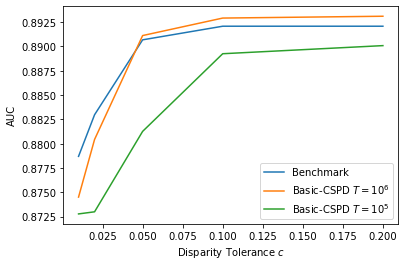

In [23]:
import matplotlib.pyplot as plt
c_list = [0.01,0.02,0.05,0.1,0.2]
plt.plot(c_list, AUC_res, label= 'Benchmark')
plt.plot(c_list, mean_AUC_T1000000, label='Basic-CSPD $T = 10^6$')
plt.plot(c_list, mean_AUC_T100000 , label='Basic-CSPD $T = 10^5$')
#plt.plot(c_list, mean_AUC_T10000, label='$T = 10^4$')
plt.xlabel('Disparity Tolerance $c$')
plt.ylabel('AUC')
plt.legend()
#plt.savefig('disparity.pdf')
plt.show()


In [33]:
# import numpy as np
# import scipy.io
# scipy.io.savemat('disparity.mat', dict(c_list = c_list, AUC_res = AUC_res, mean_AUC_T1000000 = mean_AUC_T1000000, mean_AUC_T100000 = mean_AUC_T100000))

# Plot results when $c= 0.02$

In [19]:
def Online_AUC_path(X_data,Y_data,Z_data,T,C1,C2, c, reg_coef,theta_opt):
    

    
    eta=C1/math.sqrt(T)
    beta=C1/math.sqrt(T)
    kappa = C2/math.sqrt(T)
    
    lam=np.array([1.0,1.0])
    theta= 10*theta_opt
    a = 1
    b = 1
    alpha = 1
    
    

    
    
    
    theta_average = theta
    a_average = 1
    b_average = 1
    alpha_average = alpha
    lam_average = lam
    
    best_MSE = 100
    
    MSE_result = []
    feasibility_result = []
    
    for t in range(1,T+1):
        #u=2*(constraints(X,theta_p,z)+np.dot(g_grad(X,z),(theta-theta_p)))-(constraints(X,theta_pp,z)+np.dot(g_grad(X,z),(theta_p-theta_pp)))
        #u=2*constraints(X,theta,z)-constraints(X,theta_p,z)
        #lam=lam+tau*u
        #lam=np.maximum(0,lam)
        #theta_pp=theta_p
        #theta_p=theta
        #theta=theta+eta*(f_grad(X,Y,theta)+np.dot(lam,g_grad(X,z)))
        rd=random.randint(0,num_total-1)
        
        X = X_data[rd,:]
        Y = Y_data[rd]
        Z = Z_data[rd]
        
#        print(np.shape(g_grad(X,Z)))
        nabla_L_x = f_grad_x(X,Y,theta,a,b,alpha,p,reg_coef) + np.dot(lam,g_grad(X,Z))
        
        theta = theta - eta*nabla_L_x
        a = a - eta*f_grad_a(X,Y,theta,a,b,alpha,p)
        b = b - eta*f_grad_b(X,Y,theta,a,b,alpha,p)
        alpha = alpha + kappa* f_grad_alpha(X,Y,theta,a,b,alpha,p)
        
        theta_average = (t-1)* theta_average/t + theta/t
        a_average = (t-1)* a_average/t + a/t
        b_average = (t-1)* b_average/t + b/t
        alpha_average = (t-1)* alpha_average/t + alpha/t
        
        
        u = constraints(X,theta,Z,c)
#        print(u)
        lam = lam+ beta *u
        lam = np.maximum(0,lam)
        
        lam_average = (t-1)* lam_average/t + lam/t
        
        
        
        
        if(t%100==0):
            
            this_MSE = np.linalg.norm(theta_average - theta_opt)**2
#             print("In iteration ", t, ", the AUC score is ", AUC_score(X_one,X_zero, theta_average,one_indices,zero_indices))

            temp_constraint = np.dot(Z_data,np.dot(X_data, theta_average))/num_total
            this_feasibility = np.absolute(temp_constraint)
            this_feasibility = np.maximum(this_feasibility - c,0)
            print("In iteration ", t, ", the MSE is ", this_MSE, 'the feasibility is', this_feasibility)
            MSE_result.append(this_MSE)
            feasibility_result.append(this_feasibility)
                      
    return MSE_result, feasibility_result



C1 = 0.1
C2 = 0.1




Iter = 10

Online_AUC_path_MSE = np.zeros((num_c,Iter))
Online_AUC_path_feasibility = np.zeros((num_c,Iter))
T = 100000

np.random.seed(0)

for n_iter in range(1,Iter+1):  
    i = 1   
    #c = 0.05
    this_c = c_list[i]
    this_theta_opt = theta_res[:,i]
    print('Experiment with c = ',this_c, 'and T = ',T)
    
    if n_iter == 1:
        Online_AUC_path_MSE, Online_AUC_path_feasibility  = Online_AUC_path(X_data,Y_data,Z_data,T,C1,C2, this_c, reg_coef,this_theta_opt)
    else:
        this_MSE, this_feasibility = Online_AUC_path(X_data,Y_data,Z_data,T,C1,C2, this_c, reg_coef,this_theta_opt)
        Online_AUC_path_MSE = np.array(Online_AUC_path_MSE)*(1-1/n_iter) + np.array(this_MSE)/n_iter
        Online_AUC_path_feasibility = np.array(Online_AUC_path_feasibility)*(1-1/n_iter) + np.array(this_feasibility)/n_iter

Experiment with c =  0.02 and T =  100000
In iteration  100 , the MSE is  5.76048611425341 the feasibility is 0.17020772746135363
In iteration  200 , the MSE is  5.524649578136733 the feasibility is 0.15958358781045318
In iteration  300 , the MSE is  5.280977768645754 the feasibility is 0.15016274374727095
In iteration  400 , the MSE is  5.031580878734024 the feasibility is 0.1394425173305641
In iteration  500 , the MSE is  4.787806362727768 the feasibility is 0.1319302262813069
In iteration  600 , the MSE is  4.583905136474027 the feasibility is 0.12366819608446873
In iteration  700 , the MSE is  4.405985283630193 the feasibility is 0.11359454933810252
In iteration  800 , the MSE is  4.239882702168605 the feasibility is 0.10488326231154887
In iteration  900 , the MSE is  4.079384674950752 the feasibility is 0.0963012205574448
In iteration  1000 , the MSE is  3.925259947815272 the feasibility is 0.08691950130294429
In iteration  1100 , the MSE is  3.7810854598445753 the feasibility is 

In [20]:
def Online_AUC_Adptive_path(X_data,Y_data,Z_data,T,C1,C2, c, reg_coef,theta_opt):
    

    

    lam_0 = np.array([1.0,1.0])
    theta_0= 10*theta_opt
    a_0 = 1
    b_0 = 1
    alpha_0 = 1
    
    
    lam = lam_0
    theta = theta_0
    a = a_0
    b = b_0
    alpha = alpha_0
    
    
    
    theta_average = theta_0
    a_average = 1
    b_average = 1
    alpha_average = alpha_0
    lam_average = lam_0
    
    best_MSE = 100
    
    MSE_result = []
    feasibility_result = []
    
    for t in range(1,T+1):

        this_t = max(t,10000);
        
        eta= math.sqrt(this_t)/C1
        beta= math.sqrt(this_t)/C1
        kappa = math.sqrt(this_t)/C2

        rho = (math.sqrt(this_t+1) - math.sqrt(this_t))/C1
        tau = (math.sqrt(this_t+1) - math.sqrt(this_t))/C1
        phi = (math.sqrt(this_t+1) - math.sqrt(this_t))/C2
    
    
        rd=random.randint(0,num_total-1)
        
        X = X_data[rd,:]
        Y = Y_data[rd]
        Z = Z_data[rd]
        
#        print(np.shape(g_grad(X,Z)))
        nabla_L_x = f_grad_x(X,Y,theta,a,b,alpha,p,reg_coef) + np.dot(lam,g_grad(X,Z))
        
        theta = (eta*theta + rho*theta_0 -  nabla_L_x)/(eta + rho)
        a = (eta*a + rho*a_0 - f_grad_a(X,Y,theta,a,b,alpha,p) ) /(eta + rho)
        b = (eta*b + rho*b_0 - f_grad_b(X,Y,theta,a,b,alpha,p) ) /(eta + rho)
        alpha = (kappa*alpha + phi* alpha_0 +  f_grad_alpha(X,Y,theta,a,b,alpha,p) ) / (kappa + phi)
        
        theta_average = (t-1)* theta_average/t + theta/t
        a_average = (t-1)* a_average/t + a/t
        b_average = (t-1)* b_average/t + b/t
        alpha_average = (t-1)* alpha_average/t + alpha/t
        
        
        u = constraints(X,theta,Z,c)
#        print(u)
        lam = (beta*lam  + tau*lam_0 +  u)/(beta+ tau)
        lam = np.maximum(0,lam)
        
        lam_average = (t-1)* lam_average/t + lam/t
        
        
        
        
        if(t%100==0):
            
            this_MSE = np.linalg.norm(theta_average - theta_opt)**2
#             print("In iteration ", t, ", the AUC score is ", AUC_score(X_one,X_zero, theta_average,one_indices,zero_indices))

            temp_constraint = np.dot(Z_data,np.dot(X_data, theta_average))/num_total
            this_feasibility = np.absolute(temp_constraint)
            this_feasibility = np.maximum(this_feasibility - c,0)
            print("In iteration ", t, ", the MSE is ", this_MSE, 'the feasibility is', this_feasibility)
            MSE_result.append(this_MSE)
            feasibility_result.append(this_feasibility)
                      
    return MSE_result, feasibility_result


Iter = 10

Online_AUC_Adptive_path_MSE = np.zeros((num_c,Iter))
Online_AUC_Adptive_path_feasibility = np.zeros((num_c,Iter))
T = 100000

np.random.seed(0)

for n_iter in range(1,Iter+1):  
    i = 1
    this_c = c_list[i]
    this_theta_opt = theta_res[:,i]
    print('Experiment with c = ',this_c, 'and T = ',T)
    
    if n_iter == 1:
        Online_AUC_Adptive_path_MSE, Online_AUC_Adptive_path_feasibility  = Online_AUC_Adptive_path(X_data,Y_data,Z_data,T,C1,C2, this_c, reg_coef,this_theta_opt)
    else:
        this_MSE, this_feasibility = Online_AUC_Adptive_path(X_data,Y_data,Z_data,T,C1,C2, this_c, reg_coef,this_theta_opt)
        Online_AUC_Adptive_path_MSE = np.array(Online_AUC_Adptive_path_MSE)*(1-1/n_iter) + np.array(this_MSE)/n_iter
        Online_AUC_Adptive_path_feasibility = np.array(Online_AUC_Adptive_path_feasibility)*(1-1/n_iter) + np.array(this_feasibility)/n_iter

Experiment with c =  0.02 and T =  100000
In iteration  100 , the MSE is  5.251851524132588 the feasibility is 0.10319694406235638
In iteration  200 , the MSE is  4.697020129618415 the feasibility is 0.050485436406641465
In iteration  300 , the MSE is  4.212126178943045 the feasibility is 0.0014282367134794832
In iteration  400 , the MSE is  3.793293173619438 the feasibility is 0.0
In iteration  500 , the MSE is  3.4188838245588813 the feasibility is 0.007725028706116983
In iteration  600 , the MSE is  3.081283829567542 the feasibility is 0.022116066571378972
In iteration  700 , the MSE is  2.8003796715415685 the feasibility is 0.029610916283944803
In iteration  800 , the MSE is  2.5595840561558365 the feasibility is 0.0327507328141398
In iteration  900 , the MSE is  2.354166261156478 the feasibility is 0.03421307858195716
In iteration  1000 , the MSE is  2.1732603806529838 the feasibility is 0.035872272221300724
In iteration  1100 , the MSE is  2.012437006986914 the feasibility is 0.0

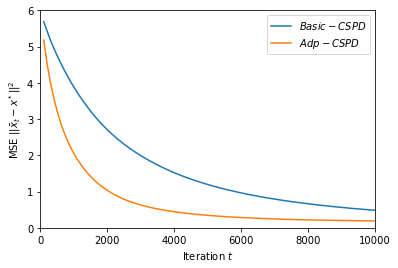

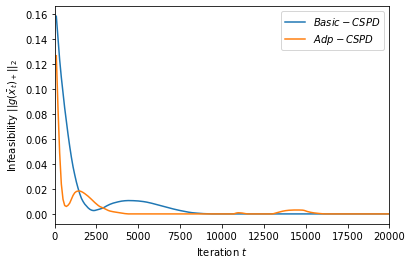

In [25]:
x_list = []
import matplotlib.pyplot as plt

for t in range(1,T+1):
    if t%100 == 0:
        x_list.append(t)
plt.plot(x_list, Online_AUC_path_MSE, label='$Basic-CSPD$')
plt.plot(x_list, Online_AUC_Adptive_path_MSE, label='$Adp-CSPD$')
plt.xlabel('Iteration $t$')
plt.ylabel('MSE $||  \\bar x_t - x^*||^2$')
plt.xlim(0,10000)
plt.ylim(0,6)
plt.legend()
#plt.savefig('MSE.pdf')
plt.show()

plt.plot(x_list, Online_AUC_path_feasibility, label='$Basic-CSPD$')
plt.plot(x_list, Online_AUC_Adptive_path_feasibility, label='$Adp-CSPD$')
plt.xlabel('Iteration $t$')
plt.ylabel('Infeasibility $||g( \\bar x_t )_+||_2$')
plt.xlim(0,20000)
plt.legend()
#plt.savefig('feasibility.pdf')
plt.show()

In [34]:
# import numpy as np
# import scipy.io
# scipy.io.savemat('MSE_infeasibility.mat', dict(x_list = x_list, Online_AUC_path_MSE = Online_AUC_path_MSE, Online_AUC_Adptive_path_MSE = Online_AUC_Adptive_path_MSE, Online_AUC_path_feasibility = Online_AUC_path_feasibility, 
#                                        Online_AUC_Adptive_path_feasibility = Online_AUC_Adptive_path_feasibility))